# Fisher Information fits (2016)

# USED IN THESIS FOR MULTI OBJECTS

This is a redo of Figure 7 in the paper, but using the last codebase.

Need to check:

* What is the Fisher Info that was really used
* If we need T or T-1 in the theoretical thing.

Later:

* Extend this to multiple objects and redo similar plots for Thesis.


In [1]:
# import os
# os.environ['PYTHONPATH'] = ''

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [30]:
import os
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.utils import io
import progress

import collections

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa
import sampler_invtransf_randomfactorialnetwork
import highdimensionnetwork

from scipy.spatial.distance import pdist

# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

sns.set_context("notebook", font_scale=1.7, rc={"lines.linewidth": 2})

In [3]:
arguments_dict = dict(
    action_to_do='launcher_check_fisher_fit_1obj_2016',
    collect_responses=None,
    inference_method='sample',
    N=400,
    num_samples=50,
    M=14**2,
    T=1,
    num_repetitions=3,
    renormalize_sigma=None,
#     rc_scale = 4.,
    autoset_parameters=None,
    label='thesis_fisherinfo_fit_1obj',
    code_type='conj',
    output_directory='./Experiments/fisherinfo_singleitem/thesisrerun_fisherinfo_fit_1obj_050816',
    ratio_conj=1.,
    sigmax=0.2,
    sigma_baseline=0.0,
    sigmay=0.00000001,  #0.17
    sigma_output=0.0,
    selection_num_samples=1,
    selection_method='last',
    slice_width=0.07,
    burn_samples=50,
    enforce_min_distance=0.0000001,
    specific_stimuli_random_centers=None,
    stimuli_generation='random_fixed_first',
#     stimuli_generation='random',
    stimuli_generation_recall='random',
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)
experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)

Arguments: ['-f', '/run/user/5201/jupyter/kernel-eae17ef6-0291-425f-87c1-7800cb5cdffc.json']
None
Doing a piece of work for launcher_check_fisher_fit_1obj_2016
{'M_layer_one': 400, 'code_type': 'conj', 'verbose': False, 'selection_num_samples': 1, 'subaction': '', 'load_all_from_parameters_file': False, 'pylab': True, 'specific_stimuli_random_centers': True, 'enforce_min_distance': 1e-07, 'result_computation': '', 'threshold': 0.0, 'slice_width': 0.07, 'rc_scale': 0.5, 'autoset_parameters': True, 'normalise_gain': False, 'job_name': '', 'experiment_data_dir': '/nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data', 'normalise_weights': 1, 'use_theoretical_cov': False, 'best_parameters_file': '', 'plot_while_running': False, 'D': 32, 'output_directory': './Experiments/fisherinfo_singleitem/thesisrerun_fisherinfo_fit_1obj_050816', 'R': 2, 'distribution_weights': 'exponential', 'T': 1, 'feat_ratio': 40.0, 'f': '/run/user/5201/jupyter/kernel-eae17ef6-0291-

In [5]:
dataio = DataIO(label='fisher_information_multiple', 
                calling_function='', 
                output_folder=os.environ['WORKDIR_DROP'] + '/Experiments/thesis_plots/multiple_objects')

=== FileIO ready: /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/thesis_plots/multiple_objects/fisher_information_multiple-699e0aa9-b02b-4c22-a491-796d70720bf6 ===


In [6]:
sampler = experiment_launcher.all_vars['sampler']
dataio = experiment_launcher.all_vars['dataio']
sampler.random_network.rc_scale

array([ 5.52021484,  5.52021484])

## Plots now

In [21]:
def extract_fisherinfo_values(experiment_launcher, values_to_plot):
    experiment_launcher.all_vars['mem_fidelity_as_fisher'] = (
        1./utils.kappa_to_stddev(experiment_launcher.all_vars['result_em_fits'][0])**2.)
    experiment_launcher.all_vars['marginal_FI'] = (
        experiment_launcher.all_vars['result_marginal_FI'][0])
    experiment_launcher.all_vars['marginal_inv_FI'] = (
        experiment_launcher.all_vars['result_marginal_inv_FI'][0])
    experiment_launcher.all_vars['marginal_inv_FI_inv'] = 1./experiment_launcher.all_vars['marginal_inv_FI']
    
    experiment_launcher.all_vars['precision'] = experiment_launcher.all_vars['result_all_precisions']
    experiment_launcher.all_vars['precision_stddev'] = (1./experiment_launcher.all_vars['result_all_precisions'])**0.5

    
    experiment_launcher.all_vars['mem_fidelity'] = (
        utils.kappa_to_stddev(experiment_launcher.all_vars['result_em_fits'][0]))
    experiment_launcher.all_vars['marginal_inv_FI_as_memfidelity'] = \
        (2.*experiment_launcher.all_vars['marginal_inv_FI'])**0.5
    experiment_launcher.all_vars['FI_theo_as_memfidelity'] = \
        (2./experiment_launcher.all_vars['result_FI_rc_theo'][0])**0.5
    experiment_launcher.all_vars['FI_theo_largeN_as_memfidelity'] = \
        (2./experiment_launcher.all_vars['result_FI_rc_theo_largeN'][0])**0.5
    experiment_launcher.all_vars['FI_theo_circulant_as_memfidelity'] = \
        (2./experiment_launcher.all_vars['result_FI_rc_theo_circulant'][0])**0.5
    experiment_launcher.all_vars['FI_theocov_as_memfidelity'] = \
        (2./experiment_launcher.all_vars['result_FI_rc_theocov'][0])**0.5
    
    experiment_launcher.all_vars['FI_curv_as_memfidelity'] = \
        (2./experiment_launcher.all_vars['result_FI_rc_curv'])**0.5
    
    experiment_launcher.all_vars['target'] = experiment_launcher.all_vars['result_em_fits'][1]
    
    result_dict = dict(mean=[], std=[], names=[])
    for value_name, value_result in values_to_plot:
        result_dict['names'].append(value_name)
        result_dict['mean'].append(utils.nanmean(experiment_launcher.all_vars[value_result]))
        result_dict['std'].append(utils.nanstd(experiment_launcher.all_vars[value_result]))

    result_dict['mean'] = np.array(result_dict['mean'])
    result_dict['std'] = np.array(result_dict['std'])
    
    return result_dict

def bars_fisherinfo_comparison(values_bars, values_bars_std, values_names, ax=None, mem_fidelity_bar=True):
    color_gen = sns.color_palette(palette='muted', n_colors=len(values_bars))
    # set_colormap = plt.cm.cubehelix

    bars_indices = np.arange(values_bars.size)
    width = 0.7

    ## Plot all as bars
    if ax is None:
        f, ax = plt.subplots(figsize=(12,6))

    for bar_i in xrange(values_bars.size):
        ax.bar(bars_indices[bar_i], values_bars[bar_i], width=width, color=color_gen[bar_i], zorder=2)
        ax.errorbar(bars_indices[bar_i] + width/2., 
                     values_bars[bar_i], 
                     yerr=values_bars_std[bar_i], 
                     ecolor='k', 
                     capsize=20, capthick=2, linewidth=2, zorder=3)

    # Add the memory fidelity multiplied by 2
    if mem_fidelity_bar:
        ax.bar(bars_indices[0], 
                2*values_bars[0], 
                width=width, 
                color=color_gen[0], 
                alpha=0.5, 
                hatch='/', linestyle='dashed', 
                zorder=1
               )
        ax.errorbar(bars_indices[0] + width/2., 
                     2*values_bars[0], 
                     yerr=2*values_bars_std[0], 
                     ecolor='k', 
                     alpha=0.3, 
                     capsize=20, capthick=2, 
                     linewidth=2, linestyle='--', fmt="none",
                     zorder=3
                    )

    ax.set_xticks(bars_indices + width/2.)
    ax.set_xticklabels(values_names)
    ax.set_xlim((-0.2, bars_indices.size))
    plt.tight_layout()
    
    return ax

In [22]:
def marginal_fi_distance_effect_twoitems(sampler, nSamples=1000, use_other_conv=False):
    theta_space = np.linspace(-np.pi, np.pi, nSamples)
    
    all_items_thetas = np.zeros((nSamples, 2, 2))
    all_items_thetas[:, 1, 0] = theta_space
    all_items_thetas[:, 1, 1] = 0.0000001
#     all_items_thetas[:, 1, 1] = utils.sample_angle(nSamples)

    inv_fi_distance = np.zeros(nSamples)
    fi_distance = np.zeros(nSamples)
    
    if use_other_conv:
        inv_conv = 1./(
            sampler.T*(sampler.sigma_x**2. + sampler.sigma_y**2.) + sampler.sigma_baseline**2.)*np.eye(sampler.M)
        print('bla')
    else:
        inv_conv = sampler.inv_covariance_fixed_contrib
    
    for item_i, items_thetas in enumerate(all_items_thetas):
        inv_fi_distance[item_i], fi_distance[item_i] = sampler.random_network.compute_sample_inverse_FI(
            inv_conv, items_thetas=items_thetas)
    
    return theta_space, inv_fi_distance, fi_distance

def plot_marginal_fi_comparions(distance_space, theta_space, fi_distance, inv_fi_distance, ax=None):    
    marginal_fi_variation = np.array([1./inv_fi_distance[np.abs(theta_space) > dd].mean() for dd in distance_space])
    
    if ax is None:
        _, ax = plt.subplots()
    
    ax.plot(distance_space, marginal_fi_variation, label='Marginal Fisher Information')
    ax.axhline(np.mean(sampler.estimate_fisher_info_theocov(use_theoretical_cov=False)), 
               color='g', label='Fisher Information')
    ax.axvline(0.17, color='k', linestyle='--', label='Experimental min distance')
    ax.legend(loc='upper left', fontsize=18, bbox_to_anchor=(1, 1))
    ax.set_xlabel('Distance between items [rad]')
    ax.set_ylabel('Fisher Information')
    
    return ax

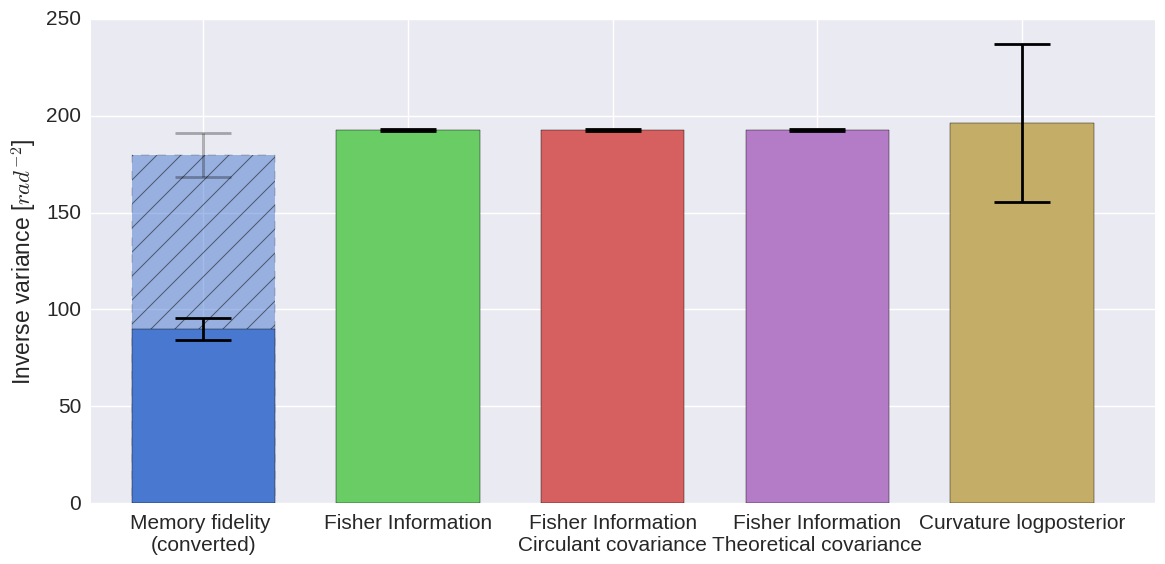

In [23]:
values_to_plot = [('Memory fidelity \n(converted)', 'mem_fidelity_as_fisher'),
#                   ('Precision', 'precision_twice'),
                  ('Fisher Information', 'result_FI_rc_theo'),
                  ('Fisher Information\nCirculant covariance', 'result_FI_rc_theo_circulant'),
                  ('Fisher Information\nTheoretical covariance', 'result_FI_rc_theocov'),
#                   ('Marginal\nFisher Information', 'marginal_inv_FI_inv'),
#                   ('Fisher Information\n Large N', 'result_FI_rc_theo_largeN'),
                  ('Curvature logposterior', 'result_FI_rc_curv'),
               ]

values_dict = extract_fisherinfo_values(experiment_launcher, values_to_plot)

ax = bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'])
ax.set_ylabel("Inverse variance [$rad^{-2}$]")
plt.tight_layout()
# dataio.save_current_figure('fisherinfo_comparison_{label}_{unique_id}.pdf')

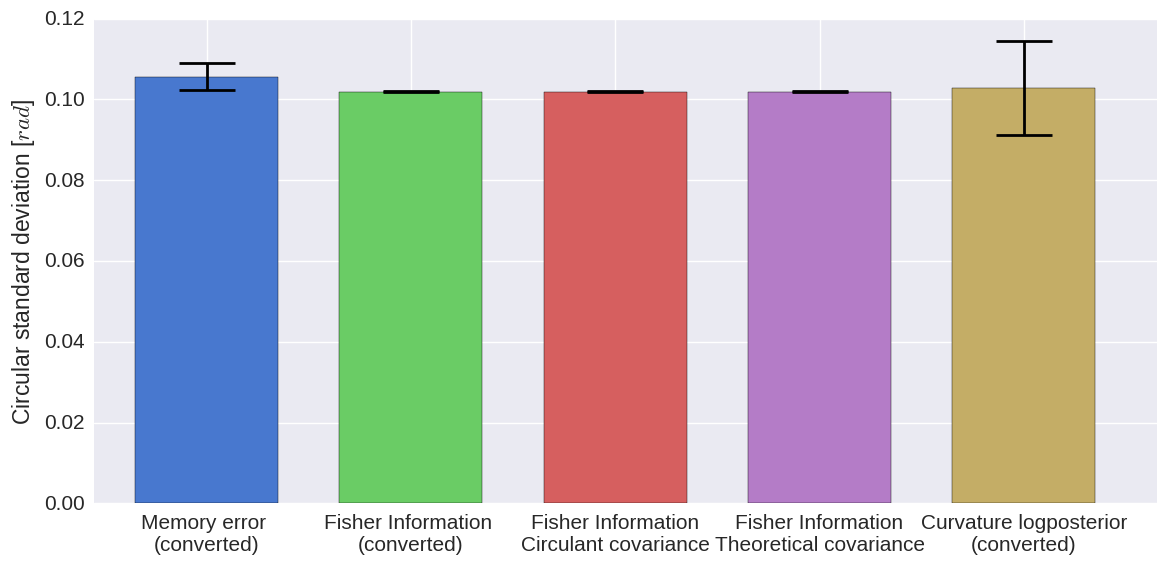

In [26]:
values_to_plot = [('Memory error \n(converted)', 'mem_fidelity'),
                  ('Fisher Information \n(converted)', 'FI_theo_as_memfidelity'),
                  ('Fisher Information\nCirculant covariance', 'FI_theo_circulant_as_memfidelity'),
                  ('Fisher Information\nTheoretical covariance', 'FI_theocov_as_memfidelity'),
#                   ('Fisher Information\nLarge N\n(converted)', 'FI_theo_largeN_as_memfidelity'),
#                   ('Marginal\nFisher Information', 'marginal_inv_FI_as_memfidelity'),
                  ('Curvature logposterior\n(converted)', 'FI_curv_as_memfidelity'),
               ]

values_dict = extract_fisherinfo_values(experiment_launcher, values_to_plot)
ax = bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'], mem_fidelity_bar=False)
ax.set_ylabel("Circular standard deviation [$rad$]")
plt.tight_layout()
# dataio.save_current_figure('fisherinfo_stddev_{label}_{unique_id}.pdf')

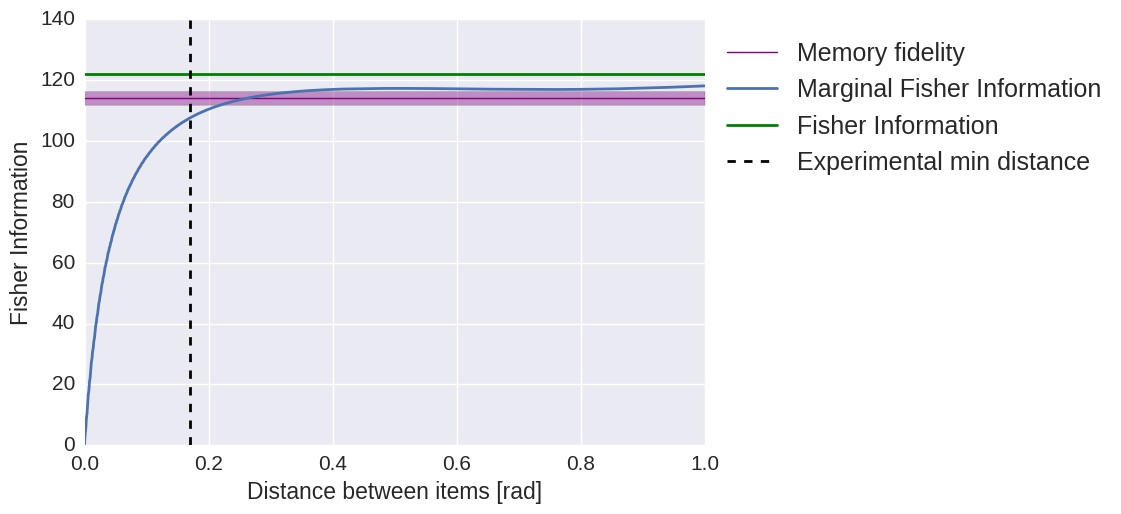

In [19]:
values_to_plot = [('Memory fidelity \n(converted)', 'mem_fidelity_as_fisher')]
values_dict = extract_fisherinfo_values(experiment_launcher, values_to_plot)

_, ax = plt.subplots()

distance_space = np.linspace(0, 1., 1000)

theta_space, inv_fi_distance, fi_distance = marginal_fi_distance_effect_twoitems(sampler, nSamples=10000)

mem_fidelity_target_mean = np.ones_like(distance_space)*values_dict['mean']*2.
mem_fidelity_target_std = np.ones_like(distance_space)*values_dict['std']*2.
utils.plot_mean_std_area(distance_space, mem_fidelity_target_mean, mem_fidelity_target_std, 
                         ax_handle=ax, label="Memory fidelity", color='purple')

plot_marginal_fi_comparions(distance_space, theta_space, fi_distance, inv_fi_distance, ax=ax)

# dataio.save_current_figure('margfisherinfo_disteffectFI_{label}_{unique_id}.pdf')

(0.12, 0.2)

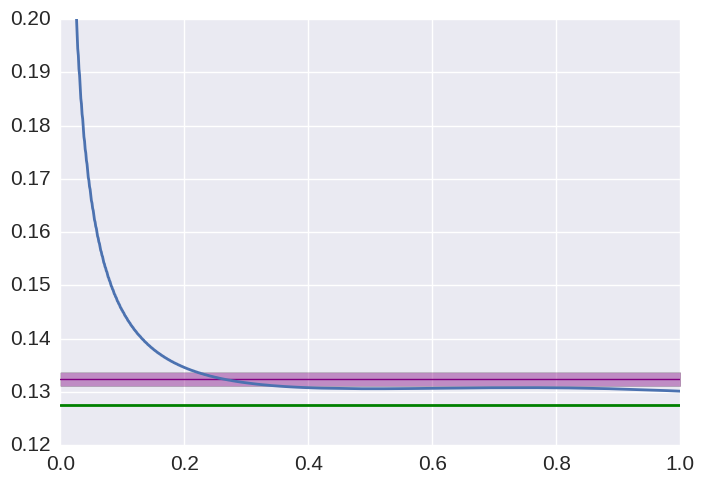

In [20]:
marginal_fi_variation = (2./np.array([1./inv_fi_distance[np.abs(theta_space) > dd].mean() for dd in distance_space]))**0.5
values_to_plot = [('Memory fidelity', 'mem_fidelity')]
values_dict = extract_fisherinfo_values(experiment_launcher, values_to_plot)
mem_fidelity_target_mean = np.ones_like(distance_space)*values_dict['mean']
mem_fidelity_target_std = np.ones_like(distance_space)*values_dict['std']


ax = utils.plot_mean_std_area(distance_space, mem_fidelity_target_mean, mem_fidelity_target_std, 
                         label="Memory fidelity", color='purple')
ax.plot(distance_space, marginal_fi_variation)
ax.axhline((2./fi_distance.mean())**0.5, color='g', label='FI')
# plt.axhline(values_dict['mean'], color='r', label='memory fidelity')

plt.ylim(0.12, 0.2)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f47c1a704d0>,
 <matplotlib.image.AxesImage at 0x7f47bf236110>)

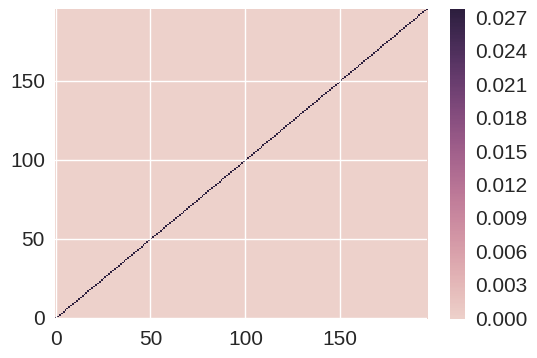

In [77]:
cmap = sns.cubehelix_palette(as_cmap=True)
utils.pcolor_2d_data(sampler.noise_covariance, cmap=cmap)
utils.pcolor_2d_data(sampler.compute_covariance_theoretical(), cmap=cmap)

True angles: 0.000 >> Inferred: -0.013


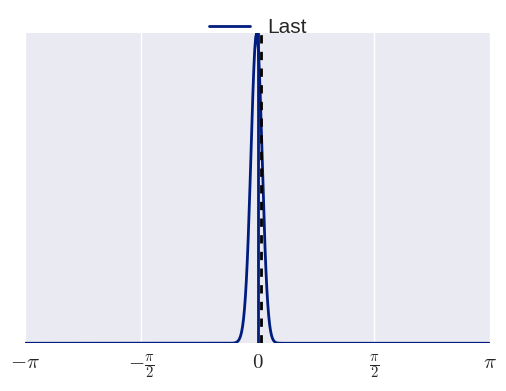

In [78]:
sns.set_palette('dark')
sampler.plot_likelihood_correctlycuedtimes(should_exponentiate=True, n=9)

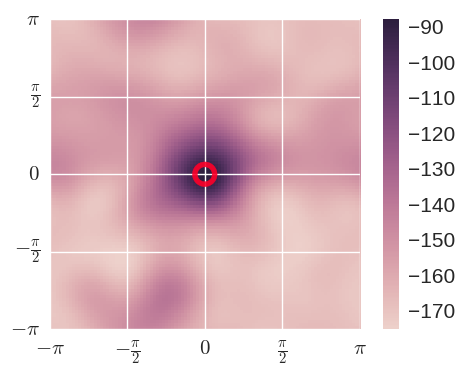

In [79]:
n=9
sampler.plot_likelihood_variation_twoangles(should_exponentiate=False, n=n, colormap=cmap)

The KL Covariance thing needs to be checked, there's an error somewhere.

Basically:

- with random stimuli, we need to take the covariance of mu(theta) into account, as we are effectively marginalising over possible items when computing Sigma_noise
- With constant stimuli, the covariance should be 0, as we are marginalising over a delta.

I'm pretty sure I could capture that properly? Or just means that in constant stimuli situation, we have another recall posterior, and another Fisher? Feels weird, even perhaps the noise_covariance is wrong for a single item, and we shouldn't really compute the covariance over N items but N-1? Naah, not sure. Hence it's two posteriors?


** ==> Fixed it. The issue was really in which Covariance we were using in the recall posterior approximation. It was wrong; we were marginalising over $\phi$ and $\psi$ in the single item case (so the noise covariance was overly bad somehow), which shouldn't happen. **

### Need to restart fit_experiments though now!
### ... hope it still works :/

## => It does, all good :)

## Small M test

In [80]:
# arguments_dict = dict(
#     action_to_do='launcher_check_fisher_fit_1obj_2016',
#     inference_method='sample',
#     N=100,
#     num_samples=50,
#     M=3**2,
#     label='thesis_fisherinfo_fit_1obj_smallM',
#     output_directory='./Experiments/fisherinfo_singleitem/thesisrerun_fisherinfo_fit_1obj_050816',
#     T=1,
#     num_repetitions=5,
#     renormalize_sigma=None,
#     autoset_parameters=None,
#     code_type='conj',
#     ratio_conj=1.,
#     sigmax=0.25,
#     sigmay=0.000001,
#     sigma_output=0.0,
#     selection_num_samples=1,
#     selection_method='last',
#     slice_width=0.07,
#     burn_samples=100,
#     enforce_min_distance=0.17,
#     specific_stimuli_random_centers=None,
#     stimuli_generation='random',
#     stimuli_generation_recall='random',
#     experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
# )
# with io.capture_output(display=False, stdout=True) as captured:
#     experiment_launcher_small = ExperimentLauncher(run=True, arguments_dict=arguments_dict)

In [81]:
# values_to_plot = [('Memory fidelity \n(converted)', 'mem_fidelity_as_fisher'),
#                   ('Fisher Information', 'result_FI_rc_theo'),
# #                   ('Fisher Information\ntheoretical covariance', 'result_FI_rc_theocov'),
#                   ('Marginal\n Fisher Information', 'marginal_inv_FI_inv'),
#                   ('Fisher Information\n Large N', 'result_FI_rc_theo_largeN'),
#                   ('Curvature logposterior', 'result_FI_rc_curv')
#                ]

# values_dict = extract_fisherinfo_values(experiment_launcher_small, values_to_plot)

# ax = bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'])
# ax.set_ylabel("Inverse variance [$rad^{-2}$]")
# plt.tight_layout()

# experiment_launcher_small.all_vars['dataio'].save_current_figure('fisherinfo_comparison_{label}_{unique_id}.pdf')

In [82]:
# values_to_plot = [('Error deviation', 'mem_fidelity'),
#                   ('Fisher Information \n(converted)', 'FI_theo_as_memfidelity'),
#                   ('Marginal\n Fisher Information', 'marginal_inv_FI_as_memfidelity'),
#                   ('Fisher Information Large N\n(converted)', 'FI_theo_largeN_as_memfidelity'),
#                   ('Curvature logposterior\n(converted)', 'FI_curv_as_memfidelity')
#                ]

# values_dict = extract_fisherinfo_values(experiment_launcher_small, values_to_plot)
# ax = bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'], mem_fidelity_bar=False)
# ax.set_ylabel("Standard deviation [$rad$]")
# plt.tight_layout()
# experiment_launcher_small.all_vars['dataio'].save_current_figure('fisherinfo_stddev_{label}_{unique_id}.pdf')

In [83]:
# sampler = experiment_launcher.all_vars['sampler']
# n = 1

# print "FI circulant:", sampler.random_network.compute_fisher_information_circulant(
#     sampler.data_gen.stimuli_correct[n, sampler.tc[n]], sampler.noise_covariance)
# print "FI normal:", sampler.random_network.compute_fisher_information(
#     stimulus_input=sampler.data_gen.stimuli_correct[n, sampler.tc[n]], inv_cov_stim=sampler.inv_covariance_fixed_contrib)

---

---

---

---


# T>1 Items situation (see below for thesis)

### Fits work as well it seems, apart from the Large N limit, which doesn't use the full covariance, hence overestimates it.

In [9]:
# Processing data 
def avg_axis(array_name, array, axis=None, out=None):
    if out is None:
        out = []
    out.append((array_name, np.mean(array, axis=axis)))
    return out

def process_inv_var(array_name, array):
    out = []
    avg_axis(array_name, array, out=out)
    avg_axis(array_name + "_stddev", (1./array)**0.5, out=out)
    return out

def process_fi(array_name, array):
    out = []
    avg_axis(array_name, array/2., out=out)
    avg_axis(array_name + "_stddev", (2./array)**0.5, out=out)
    return out

    
def process_marginal_fi(array_name, array):
    out = []
    
    # Marginal FI/Inv FI have (mean, std), just keep mean
    array = array[..., 0]
    avg_axis(array_name, array, out=out)
    
    if array_name.find('inv') > -1:
        avg_axis(array_name + "_stddev", (1.*array)**0.5, out=out)
    else:
        avg_axis(array_name + "_stddev", (1./array)**0.5, out=out)
    
    return out

def process_em_fits(array_name, array):
    out = []
    for col_i, colname in enumerate(
            ['kappa', 'target', 'nontargets', 'random', 'LL', 'bic']):
        out = avg_axis(array_name + "_" + colname, array[col_i], out=out)
        
    out = avg_axis(array_name + '_fidelity', 1./utils.kappa_to_stddev(array[0])**2., out=out)
    out = avg_axis(array_name + '_stddev', utils.kappa_to_stddev(array[0]), out=out)
    
    return out
    
def construct_pandas_dataframe(exp_launcher_all_vars, 
                               pandas_columns_with_processing, 
                               parameter_to_add=()):
    pandas_column_data = collections.defaultdict(list)

    # Extract data
    parameters = exp_launcher_all_vars['all_parameters']
    for repet_i in xrange(parameters['num_repetitions']):
        for result_array_name, result_processing in pandas_columns_with_processing:
            res_array = np.array(exp_launcher_all_vars[result_array_name])[..., repet_i]

            columns_data = result_processing['process'](result_processing['name'], res_array)
            for column_name, col_data in columns_data:
                pandas_column_data[column_name].append(col_data)

        pandas_column_data['repet'].append(repet_i)
        for param_name in parameter_to_add:
            pandas_column_data[param_name].append(parameters[parameter_to_add])
    
    df_out = pd.DataFrame(pandas_column_data)
    return df_out


In [45]:
arguments_dict = dict(
    action_to_do='launcher_check_fisher_fit_1obj_2016',
    collect_responses=None,
    inference_method='sample',
    N=200,
    num_samples=20,
    M=14**2,
    T=2,
    num_repetitions=3,
    renormalize_sigma=None,
    autoset_parameters=None,
    code_type='conj',
    label='thesis_fisherinfo_fit_conj',
    output_directory='./Experiments/fisherinfo_singleitem/thesisrerun_fisherinfo_fit_multiobj_050816',
    ratio_conj=1.0,
    sigmax=0.25,
    sigmay=0.000001,
    sigma_output=0.0,
    selection_num_samples=1,
    selection_method='last',
    slice_width=0.07,
    burn_samples=10,
    enforce_min_distance=0.000000001,  # 0.001
    enforce_distance_cued_feature_only=None,
    specific_stimuli_random_centers=None,
    stimuli_generation='random_fixed_first',
    stimuli_generation_recall='random',
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)

In [46]:
with io.capture_output(display=False, stdout=False) as captured:
    experiment_launcher_t2 = ExperimentLauncher(run=True, arguments_dict=arguments_dict)

Arguments: ['-f', '/run/user/5201/jupyter/kernel-eae17ef6-0291-425f-87c1-7800cb5cdffc.json']
None
Doing a piece of work for launcher_check_fisher_fit_1obj_2016
{'M_layer_one': 400, 'code_type': 'conj', 'verbose': False, 'selection_num_samples': 1, 'subaction': '', 'load_all_from_parameters_file': False, 'pylab': True, 'specific_stimuli_random_centers': True, 'enforce_min_distance': 1e-09, 'result_computation': '', 'threshold': 0.0, 'slice_width': 0.07, 'rc_scale': 0.5, 'autoset_parameters': True, 'normalise_gain': False, 'job_name': '', 'experiment_data_dir': '/nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data', 'normalise_weights': 1, 'use_theoretical_cov': False, 'best_parameters_file': '', 'plot_while_running': False, 'D': 32, 'output_directory': './Experiments/fisherinfo_singleitem/thesisrerun_fisherinfo_fit_multiobj_050816', 'R': 2, 'distribution_weights': 'exponential', 'T': 2, 'feat_ratio': 40.0, 'f': '/run/user/5201/jupyter/kernel-eae17ef6-0

In [47]:
# pandas_columns_with_processing = [
#     ('result_all_precisions', dict(name='precision', process=process_inv_var)),
#     ('result_FI_rc_curv', dict(name='fi_curv', process=process_fi)),
#     ('result_FI_rc_theo', dict(name='fi_theo', process=process_fi)),
#     ('result_FI_rc_theocov', dict(name='fi_theo_cov', process=process_fi)),
#     ('result_FI_rc_theo_largeN', dict(name='fi_theo_largeN', process=process_fi)),
#     ('result_FI_rc_theo_circulant', dict(name='fi_theo_circulant', process=process_fi)),
#     ('result_marginal_FI', dict(name='fi_marginal', process=process_marginal_fi)),
#     ('result_marginal_inv_FI', dict(name='inv_fi_marginal', process=process_marginal_fi)),
#     ('result_em_fits', dict(name='emfit', process=process_em_fits)),
# ]

# df_all_fits = construct_pandas_dataframe(
#     experiment_launcher_t2.all_vars, pandas_columns_with_processing)

# df_fits_flat = pd.melt(df_all_fits, id_vars=['repet'])

# df_avgstd = df_fits_flat.groupby('variable').agg(('mean', 'std')).reset_index()
# df_avgstd.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df_avgstd.columns.values]
# df_avgstd.columns = [s.split('_mean')[0] for s in df_avgstd.columns]
# df_metrics = pd.pivot_table(df_avgstd, columns='variable')

In [48]:
# values_to_plot = [
#     ('Memory fidelity \n(converted)', 'emfit_fidelity'),
# #     ('Circular precision', 'precision'),
#     ('Fisher Information', 'fi_theo'),
#     ('Fisher Information\nCirculant covariance', 'fi_theo_circulant'),
# #     ('Fisher Information\nTheoretical covariance', 'fi_theo_cov'),
#     ('Marginal\nFisher Information', 'inv_fi_marginal'),
# #     ('Fisher Information\n Large N', 'fi_theo_largeN'),
#     ('Curvature logposterior', 'fi_curv')
# ]

# df_metrics_mean = df_metrics.loc['value', [metric for name, metric in values_to_plot]]
# df_metrics_std = df_metrics.loc['value_std', [metric for name, metric in values_to_plot]]
# names = [name for name, metric in values_to_plot]

# bars_fisherinfo_comparison(df_metrics_mean, df_metrics_std, names)

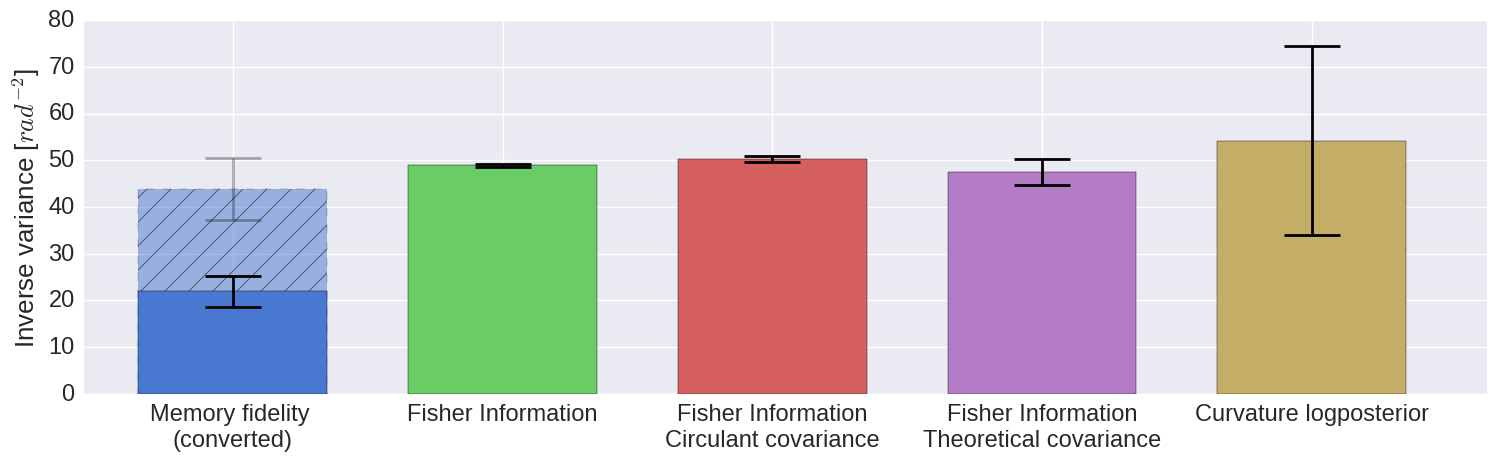

In [49]:
values_to_plot = [('Memory fidelity \n(converted)', 'mem_fidelity_as_fisher'),
                  ('Fisher Information', 'result_FI_rc_theo'),
                  ('Fisher Information\nCirculant covariance', 'result_FI_rc_theo_circulant'),
                  ('Fisher Information\nTheoretical covariance', 'result_FI_rc_theocov'),
#                   ('Marginal\nFisher Information', 'marginal_inv_FI_inv'),
#                   ('Fisher Information\n Large N', 'result_FI_rc_theo_largeN'),
                  ('Curvature logposterior', 'result_FI_rc_curv'),
               ]

values_dict = extract_fisherinfo_values(experiment_launcher_t2, values_to_plot)

f, ax = plt.subplots(figsize=(15, 5))
bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'], ax=ax)
ax.set_ylabel("Inverse variance [$rad^{-2}$]")
# plt.tight_layout()

# ax.figure.savefig(dataio.create_formatted_filename('comparison_metrics_FI_T2_conj_{label}_{unique_id}.pdf'))
# ax.figure.savefig(dataio.create_formatted_filename('comparison_allmetrics_FI_T2_conj_{label}_{unique_id}.pdf'))

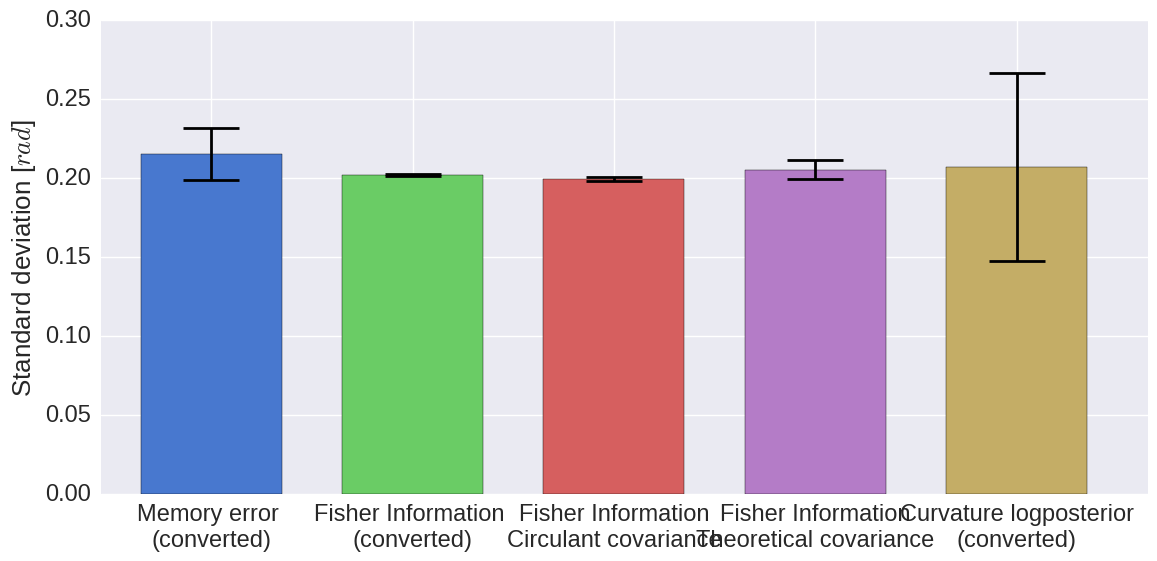

In [50]:
values_to_plot = [('Memory error \n(converted)', 'mem_fidelity'),
                  ('Fisher Information \n(converted)', 'FI_theo_as_memfidelity'),
                  ('Fisher Information\nCirculant covariance', 'FI_theo_circulant_as_memfidelity'),
                  ('Fisher Information\nTheoretical covariance', 'FI_theocov_as_memfidelity'),
                  ('Curvature logposterior\n(converted)', 'FI_curv_as_memfidelity'),
               ]

values_dict = extract_fisherinfo_values(experiment_launcher_t2, values_to_plot)
ax = bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'], mem_fidelity_bar=False)
ax.set_ylabel("Standard deviation [$rad$]")
plt.tight_layout()
# dataio.save_current_figure('fisherinfo_stddev_{label}_{unique_id}.pdf')

# What works:

1. V1 - Good for T=2, too low for others.
    1. Reduce min_distance to 0.0000001
    1. Fix phi_1 to 0, psi_1 can change.
    2. Use measured SigmaN-1.
    3. Random  stimuli for Sampler & Random SigmaN-1

In [407]:
# distance_space = np.linspace(0, np.pi/2., 1000)

# sampler = experiment_launcher_t2.all_vars['sampler']
# theta_space, inv_fi_distance, fi_distance = marginal_fi_distance_effect_twoitems(
#     sampler, nSamples=10000, use_other_conv=False)
# plot_marginal_fi_comparions(distance_space, theta_space, fi_distance, inv_fi_distance)

In [ ]:
# sampler = experiment_launcher_t2.all_vars['sampler']

# values_to_plot = [('Memory fidelity \n(converted)', 'mem_fidelity_as_fisher')]
# values_dict = extract_fisherinfo_values(experiment_launcher_t2, values_to_plot)
# _, ax = plt.subplots()

# distance_space = np.linspace(0, 1., 1000)

# theta_space, inv_fi_distance, fi_distance = marginal_fi_distance_effect_twoitems(sampler, nSamples=10000)

# mem_fidelity_target_mean = np.ones_like(distance_space)*values_dict['mean']*2.
# mem_fidelity_target_std = np.ones_like(distance_space)*values_dict['std']*2.
# utils.plot_mean_std_area(distance_space, mem_fidelity_target_mean, mem_fidelity_target_std, 
#                          ax_handle=ax, label="Memory fidelity", color='purple')

# plot_marginal_fi_comparions(distance_space, theta_space, fi_distance, inv_fi_distance, ax=ax)

# # dataio.save_current_figure('margfisherinfo_disteffectFI_{label}_{unique_id}.pdf')
# # ax.figure.savefig(dataio.create_formatted_filename('margfisherinfo_disteffectFI_T2_conj_{label}_{unique_id}.pdf'))

In [ ]:
# sampler = experiment_launcher_t2.all_vars['sampler']

# if False:
#     cmap = sns.cubehelix_palette(as_cmap=True)
#     ax_n, _ = utils.pcolor_2d_data(sampler.noise_covariance, cmap=cmap)
#     ax_t, _ = utils.pcolor_2d_data(sampler.compute_covariance_theoretical(), cmap=cmap)
#     ax_diff, _ = utils.pcolor_2d_data(np.abs(sampler.noise_covariance - sampler.compute_covariance_theoretical()), cmap=cmap)

#     ax_n.figure.savefig(dataio.create_formatted_filename('covariance_measured_{label}_{unique_id}.pdf'))
#     ax_t.figure.savefig(dataio.create_formatted_filename('covariance_theo_{label}_{unique_id}.pdf'))
#     ax_diff.figure.savefig(dataio.create_formatted_filename('covariance_diff_{label}_{unique_id}.pdf'))

## PLOTS USED IN THESIS

In [10]:
arguments_dict = dict(
    action_to_do='launcher_check_fisher_fit_1obj_2016',
    collect_responses=None,
    inference_method='sample',
    N=300,
    num_samples=20,
    M=14**2,
    T=1,
    num_repetitions=5,
    renormalize_sigma=None,
    autoset_parameters=None,
    code_type='conj',
    label='thesis_fisherinfo_fit_conj',
    output_directory='./Experiments/fisherinfo_singleitem/thesisrerun_fisherinfo_fit_multiobj_050816',
    ratio_conj=1.,
    sigmax=0.25,
    sigmay=0.000001,
    sigma_output=0.0,
    selection_num_samples=1,
    selection_method='last',
    burn_samples=10,
    enforce_min_distance=0.000000001,  # 0.001
    enforce_distance_cued_feature_only=None,
    specific_stimuli_random_centers=None,
    stimuli_generation='random_fixed_first',
    stimuli_generation_recall='random',
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)

dataio = DataIO(label='fisher_info_comparison_multiple_items', 
                calling_function='', 
                output_folder=os.environ['WORKDIR_DROP'] + '/Experiments/thesis_plots/multiple_objects')

=== FileIO ready: /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/thesis_plots/multiple_objects/fisher_info_comparison_multiple_items-505b0389-fe29-4312-ad46-4b88bb81731e ===


In [ ]:
all_experiment_launcher = []

T_space = np.arange(2, 6)

for T in progress.ProgressDisplay(T_space):
    print "==== Doing T=%d ====" % T
    arguments_dict['T'] = T
    
    with io.capture_output(display=False, stdout=True) as captured:
        all_experiment_launcher.append(ExperimentLauncher(run=True, arguments_dict=arguments_dict))

[0%] --
==== Doing T=2 ====
[25%] 16m21s
==== Doing T=3 ====


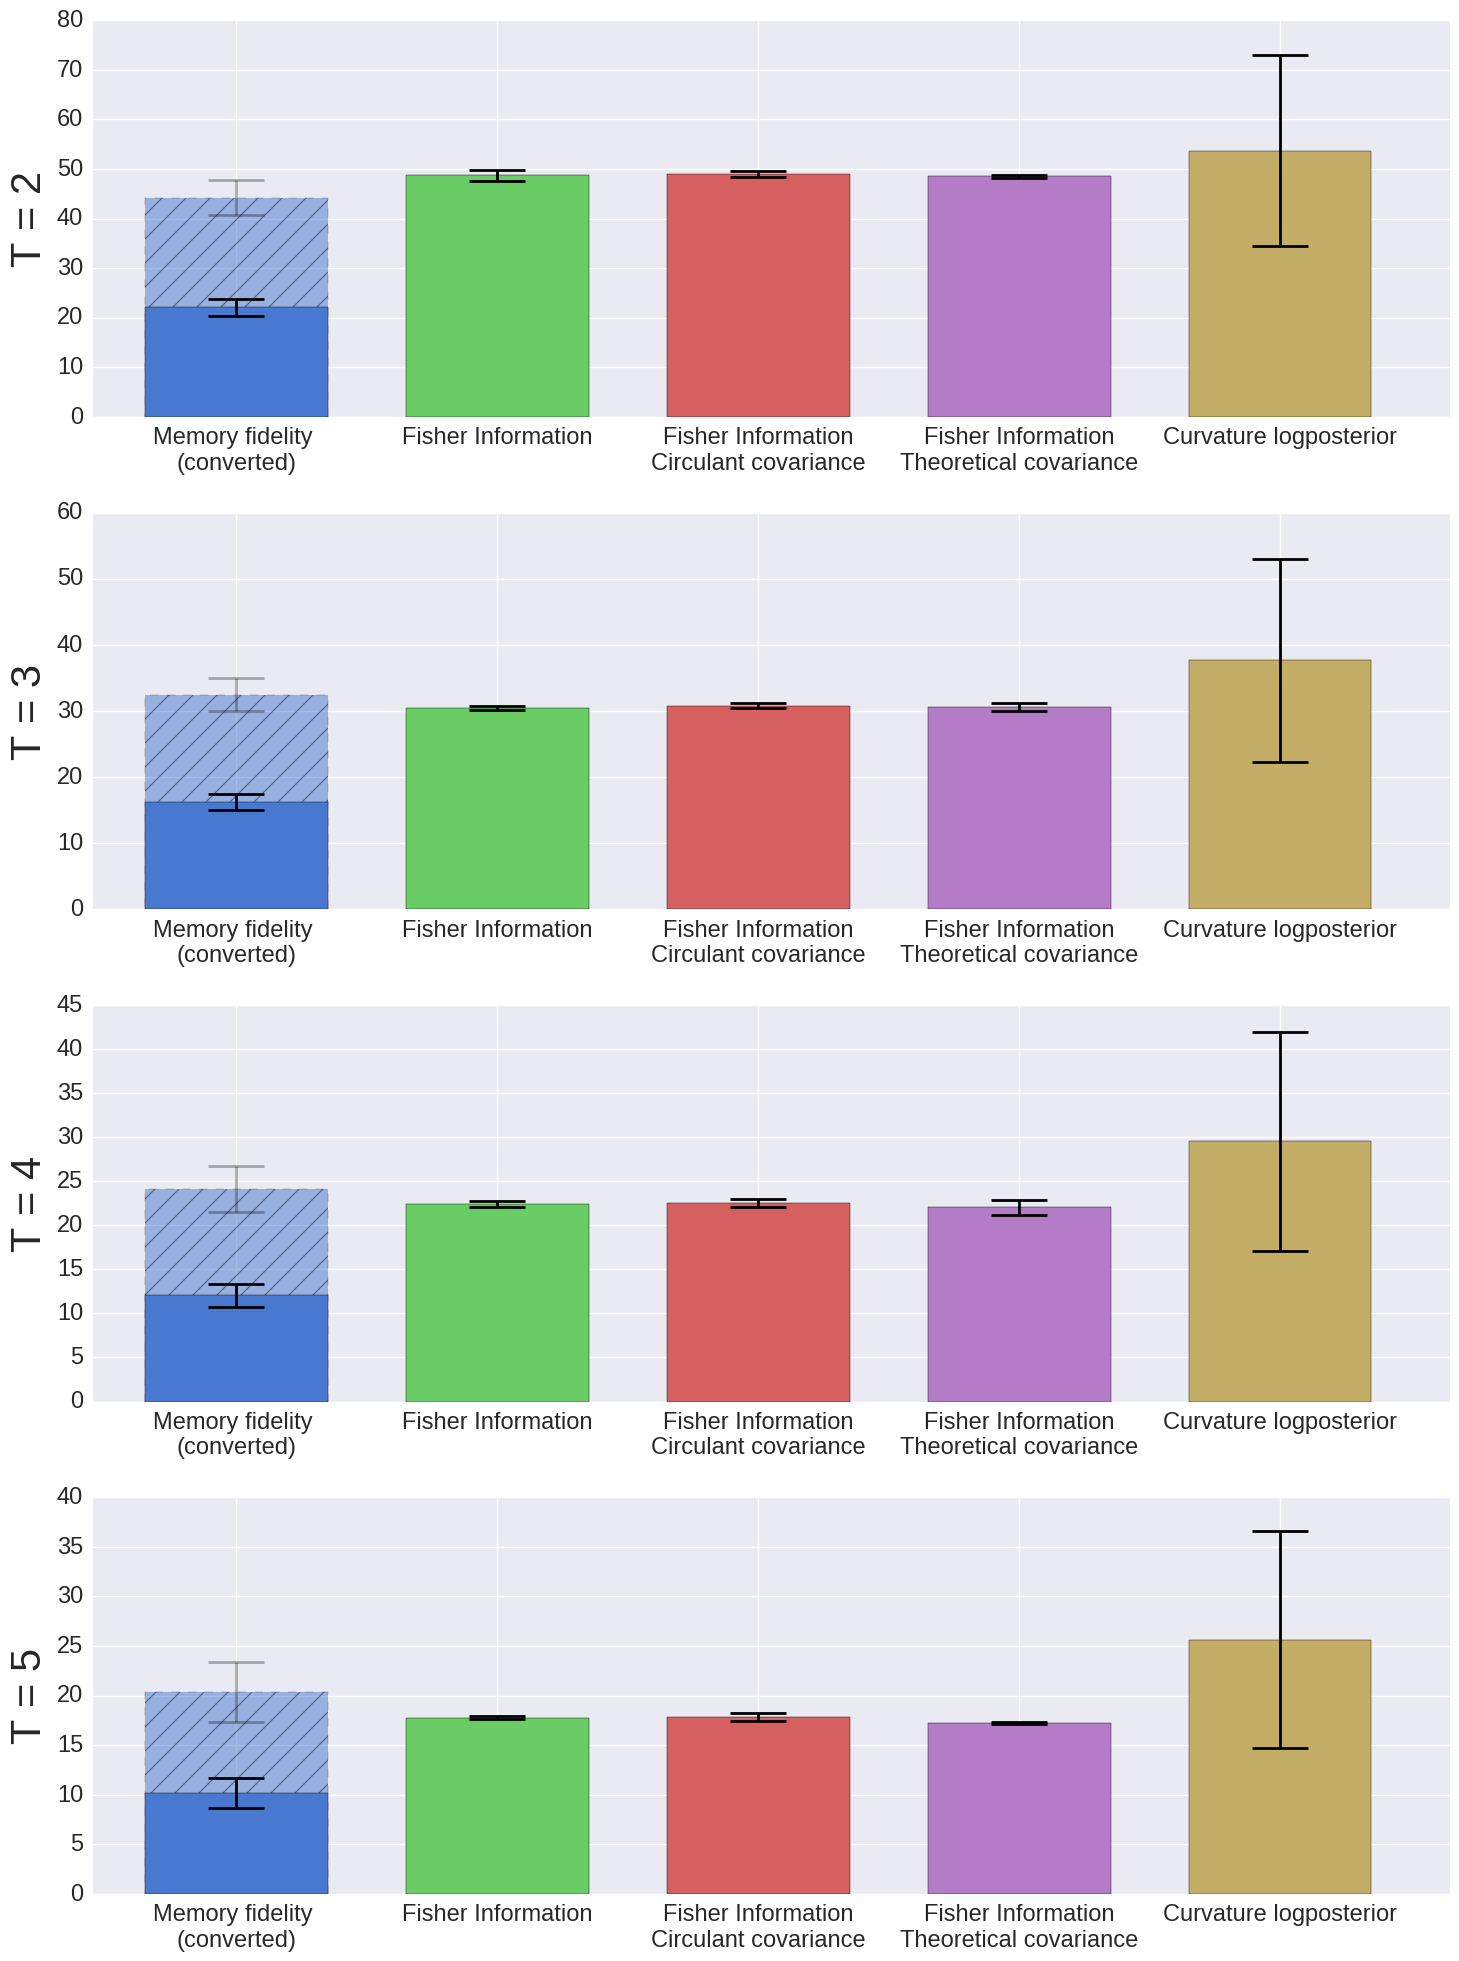

In [31]:
values_to_plot = [('Memory fidelity \n(converted)', 'mem_fidelity_as_fisher'),
                  ('Fisher Information', 'result_FI_rc_theo'),
                  ('Fisher Information\nCirculant covariance', 'result_FI_rc_theo_circulant'),
                  ('Fisher Information\nTheoretical covariance', 'result_FI_rc_theocov'),
#                   ('Marginal\nFisher Information', 'marginal_inv_FI_inv'),
#                   ('Fisher Information\n Large N', 'result_FI_rc_theo_largeN'),
                  ('Curvature logposterior', 'result_FI_rc_curv'),
               ]

values_dict = extract_fisherinfo_values(experiment_launcher_t2, values_to_plot)

f, axes = plt.subplots(T_space.size, 1, figsize=(15, 5*(T_space.size)))
for T_i, T in enumerate(T_space):
    values_dict = extract_fisherinfo_values(all_experiment_launcher[T_i], values_to_plot)
    bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'], ax=axes[T_i])
    
    axes[T_i].set_ylabel("T = %d" % T, fontsize=30)
    

f.savefig(dataio.create_formatted_filename("fisherinfo_comparison_multiitems_v2_{label}_{unique_id}.pdf"))


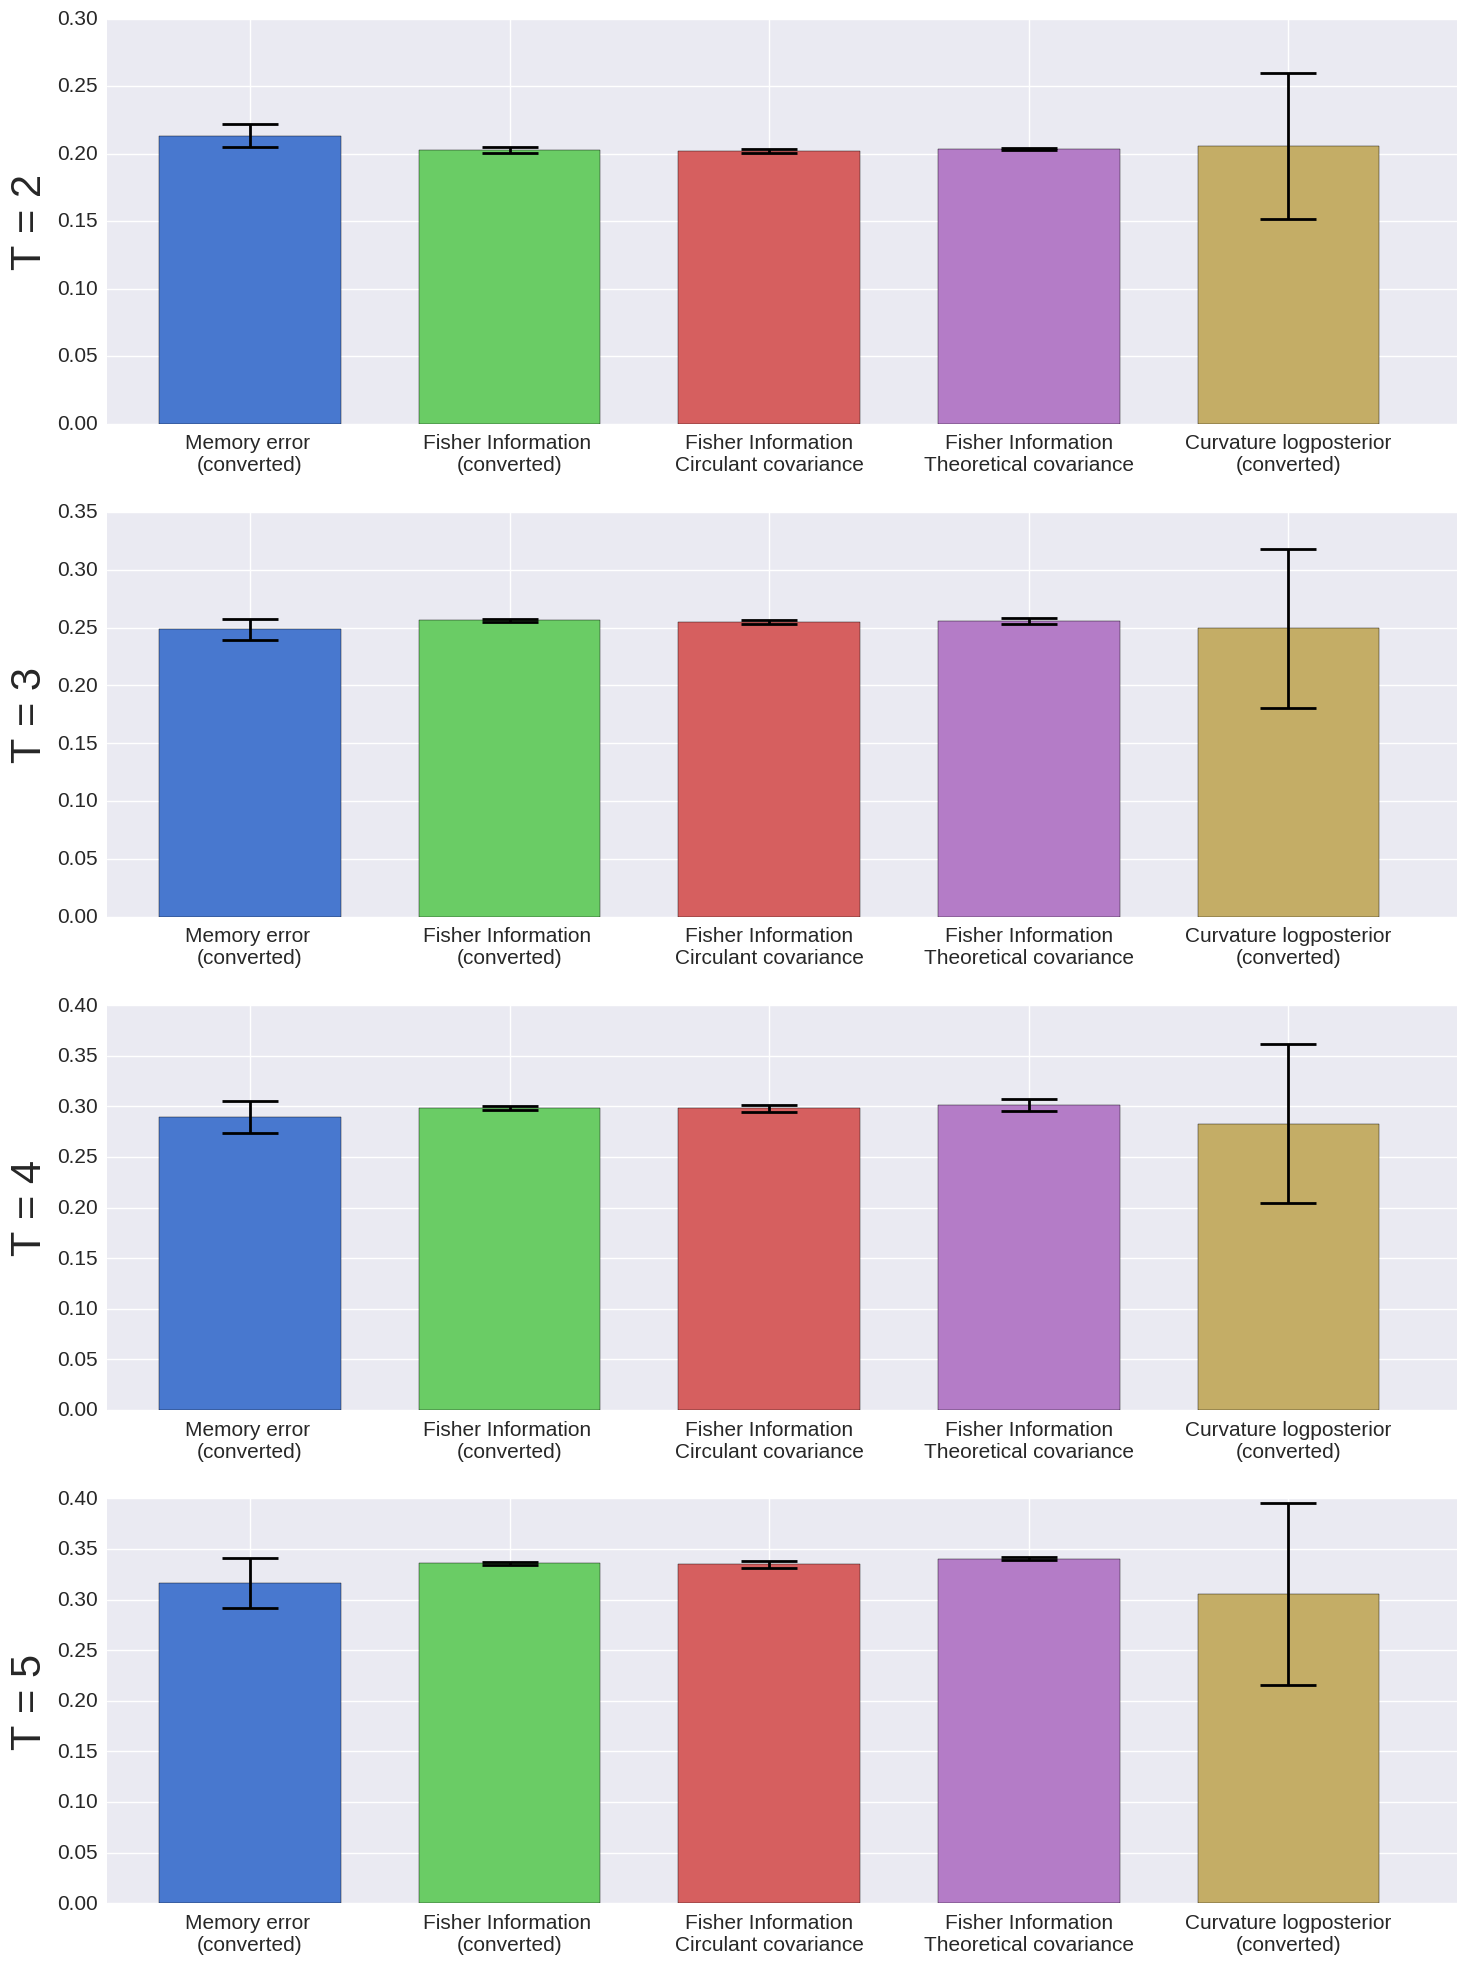

In [29]:
# Same for circular standard deviation units
values_to_plot = [('Memory error \n(converted)', 'mem_fidelity'),
                  ('Fisher Information \n(converted)', 'FI_theo_as_memfidelity'),
                  ('Fisher Information\nCirculant covariance', 'FI_theo_circulant_as_memfidelity'),
                  ('Fisher Information\nTheoretical covariance', 'FI_theocov_as_memfidelity'),
                  ('Curvature logposterior\n(converted)', 'FI_curv_as_memfidelity'),
               ]

values_dict = extract_fisherinfo_values(experiment_launcher_t2, values_to_plot)

f, axes = plt.subplots(T_space.size, 1, figsize=(15, 5*(T_space.size)))
for T_i, T in enumerate(T_space):
    values_dict = extract_fisherinfo_values(all_experiment_launcher[T_i], values_to_plot)
    bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'], ax=axes[T_i], 
                               mem_fidelity_bar=False)
    
#     axes[T_i].set_ylabel("T = %d" % T, fontsize=30)
    

f.savefig(dataio.create_formatted_filename("fisherinfo_comparison_multiitems_v2_circstddev_{label}_{unique_id}.pdf"))


In [ ]:
def diff_to_mem_fidelity(all_vars, values_to_plot):
    data = [all_vars[v[1]] for v in values_to_plot]
    target_mem_fidelity = data[0]*2
    data = np.asarray(data[1:])

    div_target_mem_fid_mean = np.zeros(data.shape[0])
    div_target_mem_fid_mean[:-1] = np.mean(data[:-1, 0] - target_mem_fidelity, axis=-1)
    div_target_mem_fid_mean[-1] = np.mean(np.mean(data[-1] - target_mem_fidelity, axis=0))

    div_target_mem_fid_std = np.zeros(data.shape[0])
    div_target_mem_fid_std[:-1] = np.std(data[:-1, 0] - target_mem_fidelity, axis=-1)
    div_target_mem_fid_std[-1] = np.std(np.mean(data[-1] - target_mem_fidelity, axis=0))
    
    return div_target_mem_fid_mean, div_target_mem_fid_std

In [ ]:
# Plot with different to Mem fidelity.
# --> Doesn't look good... Use above instead.
values_dict = extract_fisherinfo_values(experiment_launcher_t2, values_to_plot)

f, axes = plt.subplots(T_space.size, 1, figsize=(15, 5*(T_space.size)))
for T_i, T in enumerate(T_space):
    div_target_mem_fid_mean, div_target_mem_fid_std = diff_to_mem_fidelity(
        all_experiment_launcher[T_i].all_vars, values_to_plot)
    bars_fisherinfo_comparison(div_target_mem_fid_mean, div_target_mem_fid_std, 
                               values_dict['names'][1:], ax=axes[T_i])
    axes[T_i].set_ylabel("T = %d" % T, fontsize=30)
    

## Mixed code

In [24]:
arguments_dict['code_type'] = 'mixed'
arguments_dict['ratio_conj'] = 0.7
arguments_dict['num_repetitions'] = 1
arguments_dict['label'] = 'thesis_fisherinfo_fit_conj'

T_space = np.array([2])

all_experiment_launcher_mixed = []
for T in progress.ProgressDisplay(T_space):
    print "==== Doing T=%d ====" % T
    arguments_dict['T'] = T
    
    with io.capture_output(display=False, stdout=True) as captured:
        all_experiment_launcher_mixed.append(ExperimentLauncher(run=True, arguments_dict=arguments_dict))


[0%] --
==== Doing T=2 ====
[100%] 25s


/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in divide
  # This is added back by InteractiveShellApp.init_path()


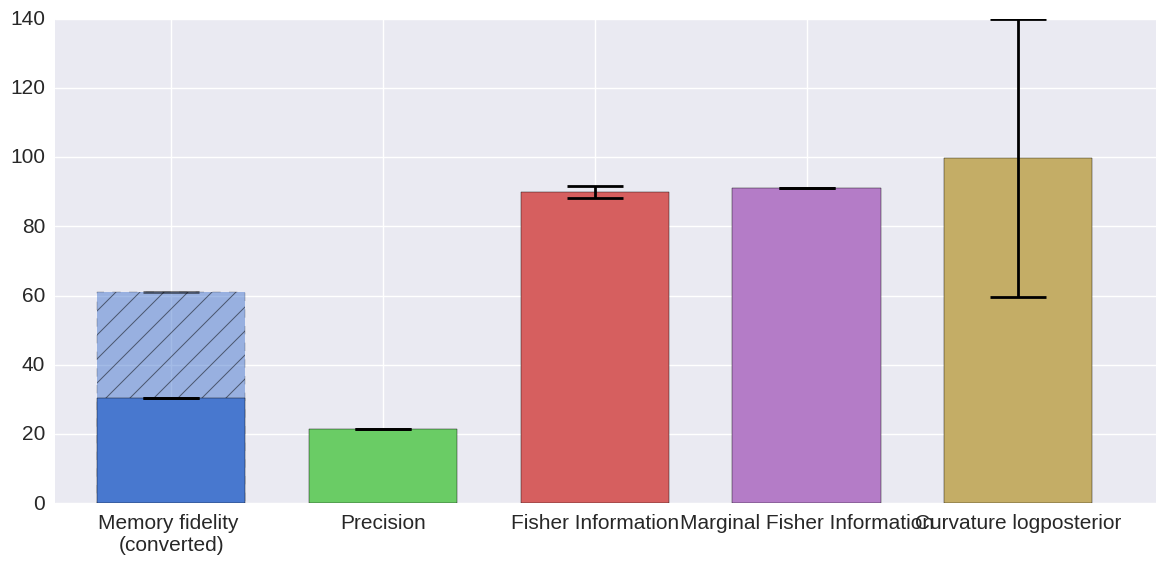

In [261]:
values_to_plot = [('Memory fidelity \n(converted)', 'mem_fidelity_as_fisher'),
                  ('Fisher Information', 'result_FI_rc_theo'),
#                   ('Fisher Information\ntheoretical covariance', 'result_FI_rc_theocov'),
                  ('Marginal Fisher Information', 'marginal_inv_FI_inv'),
                  ('Curvature logposterior', 'result_FI_rc_curv')
               ]
values_dict = extract_fisherinfo_values(all_experiment_launcher_mixed[0], values_to_plot)
bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'])
    
# f, axes = plt.subplots(T_space.size, 1, figsize=(10, 5*T_space.size))

# for T_i, T in enumerate(T_space):
#     values_dict = extract_fisherinfo_values(all_experiment_launcher_mixed[T_i], values_to_plot)
#     bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'], ax=axes[T_i])
    
#     axes[T_i].set_ylabel("T = %d" % T, fontsize=30)

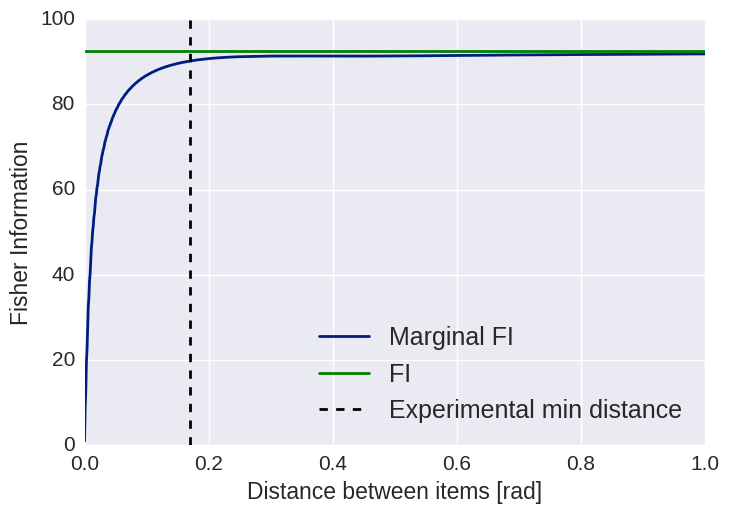

In [26]:
sampler = all_experiment_launcher_mixed[0].all_vars['sampler']
theta_space, inv_fi_distance, fi_distance = marginal_fi_distance_effect_twoitems(sampler, nSamples=10000)
plot_marginal_fi_comparions(distance_space, theta_space, fi_distance, inv_fi_distance)

## Playing with Covariance KL and circulant property

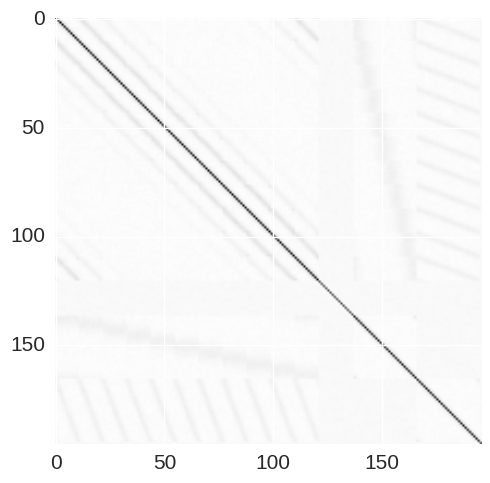

In [27]:
plt.imshow(sampler.noise_covariance)

In [198]:
print "FI circulant", np.mean(sampler.estimate_fisher_info_circulant())
print "FI classic", np.mean(sampler.estimate_fisher_info_theocov(use_theoretical_cov=False))

FI circulant 67.4908682899
FI classic 68.6594702898


## Checking weird situation where FI doesn't follow Kappa if ratio=0.7 with T=2 ...

In [223]:
# arguments_dict = dict(
#     action_to_do='launcher_check_fisher_fit_1obj_2016',
#     collect_responses=None,
#     inference_method='sample',
#     N=200,
#     num_samples=50,
#     M=400,
#     T=2,
#     num_repetitions=5,
#     renormalize_sigma=None,
#     autoset_parameters=None,
#     label='thesis_fisherinfo_fit_ratioconj07',
#     code_type='mixed',
#     output_directory='./Experiments/fisherinfo_singleitem/thesisrerun_fisherinfo_fit_multiobj_050816',
#     ratio_conj=0.7,
#     sigmax=0.25,
#     sigmay=0.000001,
#     sigma_baseline=0.0,
#     sigma_output=0.0,
#     selection_num_samples=1,
#     selection_method='last',
#     slice_width=0.07,
#     burn_samples=100,
#     enforce_min_distance=0.17,
#     specific_stimuli_random_centers=None,
#     stimuli_generation='random',
#     stimuli_generation_recall='random',
#     experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
# )
# with io.capture_output(display=False, stdout=True) as captured:
#     experiment_launcher_ratio07 = ExperimentLauncher(run=True, arguments_dict=arguments_dict)

In [224]:
# values_to_plot = [('Memory fidelity \n(converted)', 'mem_fidelity_as_fisher'),
#                   ('Fisher Information', 'result_FI_rc_theo'),
#                   ('Fisher Information\ntheoretical covariance', 'result_FI_rc_theocov'),
#                   ('Marginal Fisher Information', 'marginal_inv_FI_inv'),
#                   ('Curvature logposterior', 'result_FI_rc_curv')
#                ]

# values_dict = extract_fisherinfo_values(experiment_launcher_ratio07, values_to_plot)
# bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'])

In [225]:
# values_to_plot = [('Memory fidelity', 'mem_fidelity'),
#                   ('Fisher Information', 'FI_theo_as_memfidelity'),
#                   ('Marginal Fisher Information', 'marginal_inv_FI_as_memfidelity'),
#                   ('Curvature logposterior', 'FI_curv_as_memfidelity')
#                ]

# values_dict = extract_fisherinfo_values(experiment_launcher_ratio07, values_to_plot)
# bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'], mem_fidelity_bar=False)

### Check if it was due to errors in the M/ratio

In [222]:
M_fix, ratio_fix = utils.fix_M_ratioconj(400, 0.7)

In [223]:
arguments_dict = dict(
    action_to_do='launcher_check_fisher_fit_1obj_2016',
    collect_responses=None,
    inference_method='sample',
    N=1000,
    num_samples=50,
    M=M_fix,
    T=2,
    num_repetitions=3,
    renormalize_sigma=None,
    autoset_parameters=None,
    label='thesis_fisherinfo_fit_ratioconj07',
    code_type='mixed',
    output_directory='./Experiments/fisherinfo_singleitem/thesisrerun_fisherinfo_fit_multiobj_050816',
    ratio_conj=ratio_fix,
    sigmax=0.2,
    sigmay=0.000001,
    sigma_baseline=0.0001,
    sigma_output=0.0,
    selection_num_samples=1,
    selection_method='last',
    slice_width=0.07,
    burn_samples=100,
    enforce_min_distance=0.000001,
    stimuli_generation='random',
#     stimuli_generation_recall='random_fixed_first',  # works
    stimuli_generation_recall='random',  # doesn't work
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)
with io.capture_output(display=False, stdout=False) as captured:
    experiment_launcher_ratio07 = ExperimentLauncher(run=True, arguments_dict=arguments_dict)

Arguments: ['-f', '/run/user/5201/jupyter/kernel-fb26d8bb-2033-4ec8-978a-1a52270decf3.json']
None
Doing a piece of work for launcher_check_fisher_fit_1obj_2016
{'M_layer_one': 400, 'code_type': 'mixed', 'verbose': False, 'selection_num_samples': 1, 'subaction': '', 'load_all_from_parameters_file': False, 'pylab': True, 'specific_stimuli_random_centers': False, 'enforce_min_distance': 1e-06, 'result_computation': '', 'threshold': 0.0, 'slice_width': 0.07, 'rc_scale': 0.5, 'autoset_parameters': True, 'job_name': '', 'experiment_data_dir': '/nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data', 'normalise_weights': 1, 'use_theoretical_cov': False, 'best_parameters_file': '', 'plot_while_running': False, 'D': 32, 'output_directory': './Experiments/fisherinfo_singleitem/thesisrerun_fisherinfo_fit_multiobj_050816', 'R': 2, 'distribution_weights': 'exponential', 'T': 2, 'feat_ratio': 40.0, 'f': '/run/user/5201/jupyter/kernel-fb26d8bb-2033-4ec8-978a-1a52270de

/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in divide
  if sys.path[0] == '':


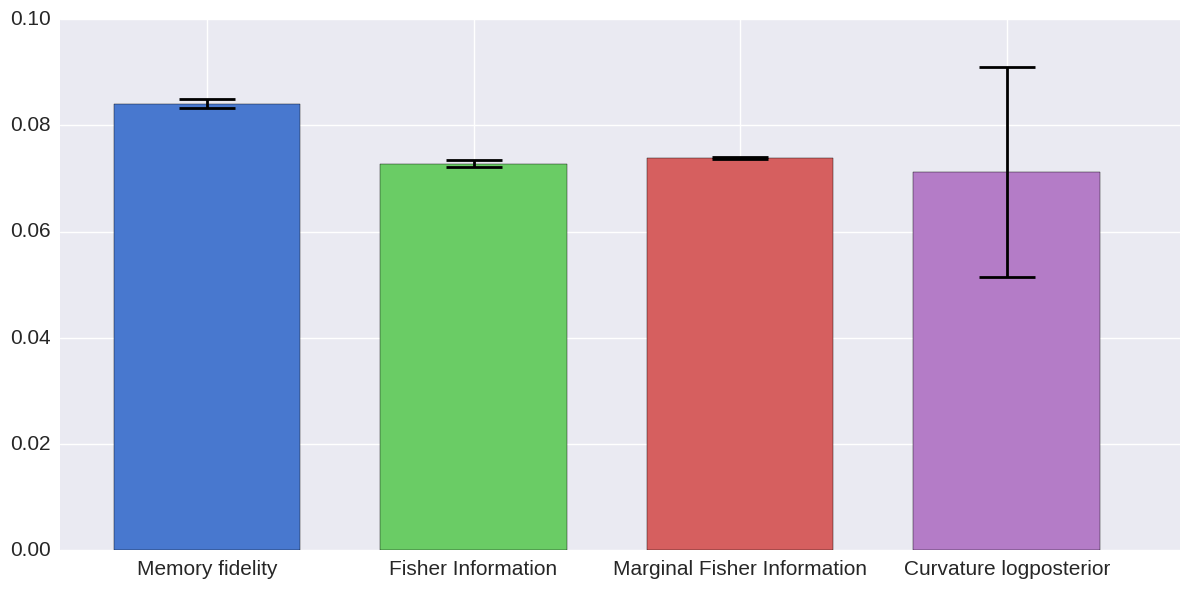

In [224]:
values_to_plot = [('Memory fidelity', 'mem_fidelity'),
                  ('Fisher Information', 'FI_theo_as_memfidelity'),
                  ('Marginal Fisher Information', 'marginal_inv_FI_as_memfidelity'),
                  ('Curvature logposterior', 'FI_curv_as_memfidelity'),
                 ]

values_dict = extract_fisherinfo_values(experiment_launcher_ratio07, values_to_plot)
bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'], mem_fidelity_bar=False)

/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in divide
  if sys.path[0] == '':


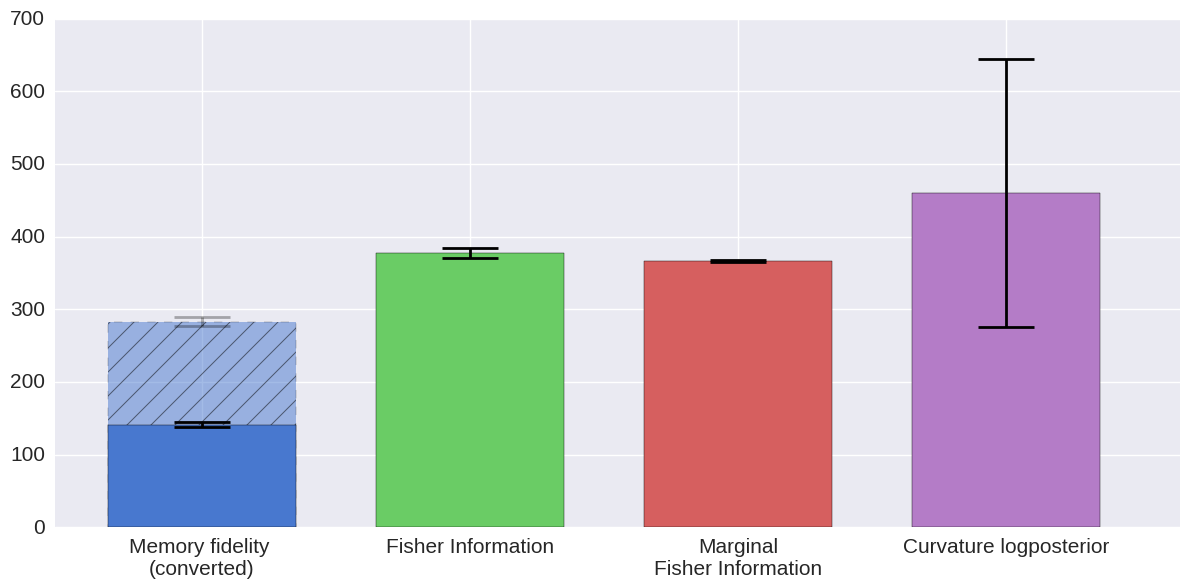

In [225]:
values_to_plot = [('Memory fidelity \n(converted)', 'mem_fidelity_as_fisher'),
                  ('Fisher Information', 'result_FI_rc_theo'),
#                   ('Fisher Information\ntheoretical covariance', 'result_FI_rc_theocov'),
                  ('Marginal\nFisher Information', 'marginal_inv_FI_inv'),
                  ('Curvature logposterior', 'result_FI_rc_curv'),
#                   ('Precision', 'precision_twice'),
                 ]

values_dict = extract_fisherinfo_values(experiment_launcher_ratio07, values_to_plot)
bars_fisherinfo_comparison(values_dict['mean'], values_dict['std'], values_dict['names'])

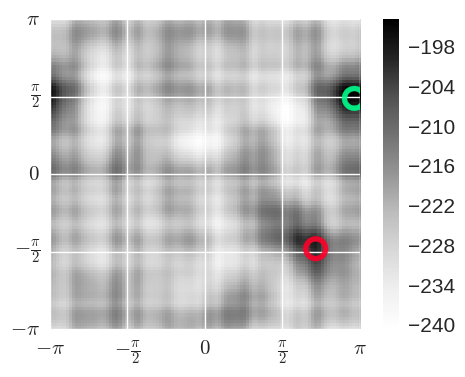

In [226]:
sampler = experiment_launcher_ratio07.all_vars['sampler']
sampler.plot_likelihood_variation_twoangles(n=2)

True angles: 3.032 | 2.249 >> Inferred: 2.853 | 2.187


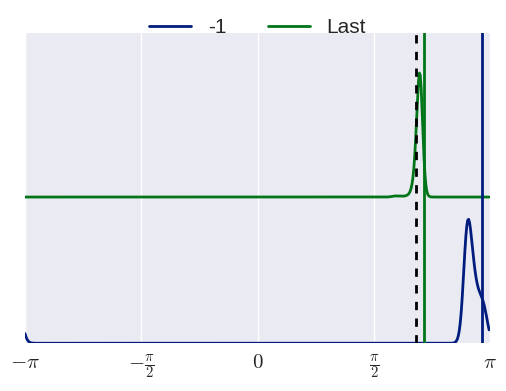

In [227]:
sampler.plot_likelihood_correctlycuedtimes(n=2)

In [228]:
sampler.data_gen.stimuli_correct.shape

(1000, 2, 2)

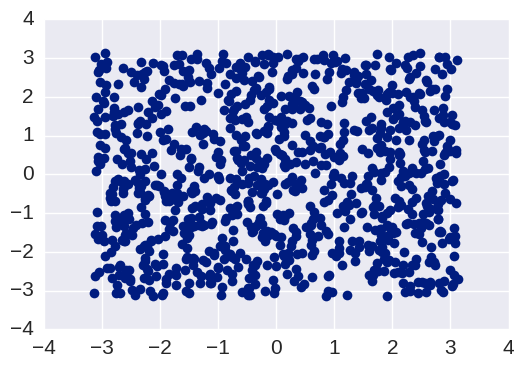

In [229]:
plt.plot(sampler.data_gen.stimuli_correct[:, 0, 0], sampler.data_gen.stimuli_correct[:, 0, 1], 'o')

In [230]:
sampler.inv_covariance_fixed_contrib

array([[  1.01472647e+01,  -6.94858742e-01,  -1.52344310e-01, ...,
          1.55674149e-02,  -9.65330098e-02,  -3.05951091e-01],
       [ -6.94858742e-01,   1.00202958e+01,  -5.30270122e-01, ...,
          5.08906749e-03,   3.17669178e-02,  -5.27469878e-03],
       [ -1.52344310e-01,  -5.30270122e-01,   1.02877882e+01, ...,
          1.78156978e-02,   1.24967220e-01,   8.16068952e-02],
       ..., 
       [  1.55674149e-02,   5.08906749e-03,   1.78156978e-02, ...,
          1.00845553e+01,  -5.17696815e-01,  -7.82546400e-02],
       [ -9.65330098e-02,   3.17669178e-02,   1.24967220e-01, ...,
         -5.17696815e-01,   1.04745010e+01,  -5.75879197e-01],
       [ -3.05951091e-01,  -5.27469878e-03,   8.16068952e-02, ...,
         -7.82546400e-02,  -5.75879197e-01,   1.03290021e+01]])

In [231]:
self = sampler
inv_covariance = np.linalg.inv(
            self.T*(self.sigma_x**2. + self.sigma_y**2.)*np.eye(self.M) +
            self.sigma_baseline**2.*np.eye(self.M))
inv_covariance

array([[ 10.83094416,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  10.83094416,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,  10.83094416, ...,   0.        ,
          0.        ,   0.        ],
       ..., 
       [  0.        ,   0.        ,   0.        , ...,  10.83094416,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
         10.83094416,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,  10.83094416]])

In [232]:
sampler.data_gen.stimuli_correct[0]

array([[-1.08149137,  1.03751445],
       [ 1.64578161,  2.01178812]])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f47b5867bd0>,
 <matplotlib.image.AxesImage at 0x7f47b58365d0>)

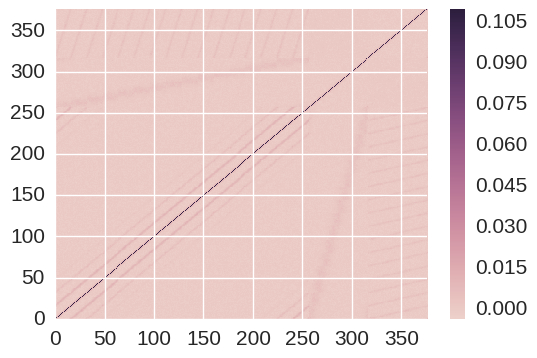

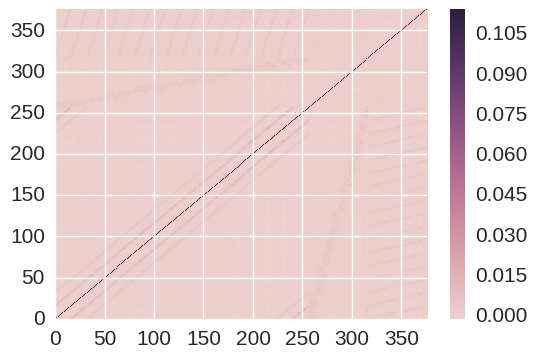

In [233]:
sampler = experiment_launcher_ratio07.all_vars['sampler']

cmap = sns.cubehelix_palette(as_cmap=True)
utils.pcolor_2d_data(sampler.noise_covariance, cmap=cmap)
utils.pcolor_2d_data(sampler.compute_covariance_theoretical(), cmap=cmap)